In [1]:
!nvidia-smi

Thu May 19 10:43:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    51W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import os
from PIL import Image
import torch 
import numpy as np 
import glob
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import segmentation_models_pytorch as smp
from trainer import Trainer
from data import StasDataset, Train_Preprocessor, Test_Preprocessor
from config import *
from vision_transformer import SwinUnet
from transformers import MaskFormerModel

In [3]:
np.random.seed(seed)
image_path_list = sorted(glob.glob(train_image_dir + "*.jpg"))
split_index = int(len(image_path_list) * train_ratio)
train_path_list = image_path_list[:split_index]
test_path_list = image_path_list[split_index:]

In [4]:
train_data = StasDataset(train_path_list, label_dir, image_transform=Train_Preprocessor(train_img_size, 
                                                                                        h_flip_p=h_flip_p, 
                                                                                        v_flip_p=v_flip_p))

test_data = StasDataset(test_path_list, label_dir, image_transform=Test_Preprocessor(test_img_size))

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, num_workers=4)

In [5]:
data, label = train_data[2]

In [6]:
data.shape

torch.Size([3, 384, 384])

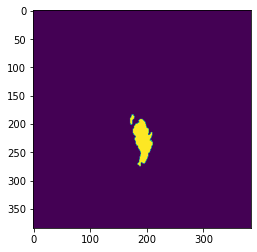

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


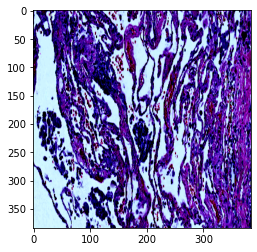

In [7]:
plt.imshow(label[0]/2)
plt.show()

plt.imshow(data.permute(1, 2, 0))
plt.show()

In [8]:
model = smp.Unet(
    encoder_name="tu-tf_efficientnetv2_l_in21k",     
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,
    decoder_attention_type='scse'
    ).to(DEVICE)

# 384, 480
# tu-tf_efficientnetv2_l_in21k
# model = MaskFormerModel.from_pretrained("facebook/maskformer-swin-base-ade")
# model = SwinUnet().to(DEVICE)

In [9]:
# https://stackoverflow.com/questions/68611397/pos-weight-in-binary-cross-entropy-calculation
class bce_dice_loss(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = smp.utils.losses.DiceLoss(activation='sigmoid')
    
    def forward(self, predictions, targets): 
        return self.bce_loss(predictions, targets) + self.dice_loss(predictions, targets)


decay_fn = lambda n: 1
# loss_fn = smp.utils.losses.DiceLoss(activation='sigmoid')
loss_fn = smp.utils.losses.DiceLoss(activation='sigmoid')

# lm.GDiceLossV2(nn.Softmax(dim=1), do_bg=False, smooth=1e-5)
# lm.IoULoss(nn.Softmax(dim=1), batch_dice=True, do_bg=False, smooth=1e-6, square=True)
# lm.SoftDiceLoss(nn.Softmax(dim=1), batch_dice=True, do_bg=False, smooth=1e-6, square=True)
# lm.BceLoss()
# lm.BceDiceLoss()

metric_dict = {
    'IOU': smp.utils.metrics.IoU(threshold=0.5),
    'Accuracy': smp.utils.metrics.Accuracy(), 
    'DICE': smp.utils.losses.DiceLoss(activation='sigmoid')
}


save_config = {
    "path": './resunet.pt', 
    "freq": 1
}

In [10]:
%%time
train_pipeline = Trainer()
train_pipeline.compile(optim_cls, decay_fn, loss_fn, metric_dict, is_sam, DEVICE, **optim_dict)
train_pipeline.fit(model, train_dataloader, test_dataloader, num_epoch, save_config)

100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.865]

train_loss: 0.9523190773399183


{'IOU': 0.06091538816690445, 'Accuracy': 0.7458813786506653, 'DICE': 0.9311330318450928}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.892]

train_loss: 0.9099632924495462


{'IOU': 0.2437325119972229, 'Accuracy': 0.9470793604850769, 'DICE': 0.9012400507926941}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.877]

train_loss: 0.8636709507617204


{'IOU': 0.29807791113853455, 'Accuracy': 0.9612206816673279, 'DICE': 0.8622336983680725}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.556]

train_loss: 0.7723246975983987


{'IOU': 0.6238135099411011, 'Accuracy': 0.9905853271484375, 'DICE': 0.716225266456604}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.317]

train_loss: 0.5765606701707041


{'IOU': 0.6104387640953064, 'Accuracy': 0.9900993704795837, 'DICE': 0.5056939125061035}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.418]

train_loss: 0.39030001076906085


{'IOU': 0.6893067955970764, 'Accuracy': 0.9935615062713623, 'DICE': 0.35286185145378113}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.206]

train_loss: 0.2679915806434674


{'IOU': 0.7194365859031677, 'Accuracy': 0.9939435124397278, 'DICE': 0.25835728645324707}


100%|██████████| 56/56 [00:31<00:00,  1.80it/s, loss=0.402]

train_loss: 0.23319644954617463


{'IOU': 0.7194952964782715, 'Accuracy': 0.9941941499710083, 'DICE': 0.2319125235080719}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.189] 

train_loss: 0.19230198254132405


{'IOU': 0.7290338277816772, 'Accuracy': 0.9945833683013916, 'DICE': 0.19869917631149292}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.188] 

train_loss: 0.16316217517053616


{'IOU': 0.732789158821106, 'Accuracy': 0.9944127798080444, 'DICE': 0.18635395169258118}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.112] 

train_loss: 0.1623666596812243


{'IOU': 0.7325149774551392, 'Accuracy': 0.9943887591362, 'DICE': 0.1804557740688324}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.139] 

train_loss: 0.14653112628606443


{'IOU': 0.7445460557937622, 'Accuracy': 0.9946798086166382, 'DICE': 0.16808824241161346}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.101] 

train_loss: 0.14353981990387985


{'IOU': 0.7369377613067627, 'Accuracy': 0.9944294095039368, 'DICE': 0.17109772562980652}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.136] 

train_loss: 0.1355675384985002


{'IOU': 0.74362713098526, 'Accuracy': 0.9947339296340942, 'DICE': 0.16271334886550903}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.166] 

train_loss: 0.13434608668588394


{'IOU': 0.6978275179862976, 'Accuracy': 0.993935227394104, 'DICE': 0.19131138920783997}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.097] 

train_loss: 0.12326617873580763


{'IOU': 0.7344136238098145, 'Accuracy': 0.9943529963493347, 'DICE': 0.16481569409370422}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.129] 

train_loss: 0.12391780947839748


{'IOU': 0.7308101058006287, 'Accuracy': 0.9943445324897766, 'DICE': 0.16674290597438812}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.112] 

train_loss: 0.12064198555227099


{'IOU': 0.7465265393257141, 'Accuracy': 0.9947307109832764, 'DICE': 0.15474101901054382}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0916]

train_loss: 0.11597344322577535


{'IOU': 0.7654616832733154, 'Accuracy': 0.9951487183570862, 'DICE': 0.14087429642677307}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0688]

train_loss: 0.113707777641339


{'IOU': 0.7291238903999329, 'Accuracy': 0.9944594502449036, 'DICE': 0.16389904916286469}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0752]

train_loss: 0.11704818483171517


{'IOU': 0.758105993270874, 'Accuracy': 0.9950146675109863, 'DICE': 0.14434775710105896}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.142] 

train_loss: 0.10527897467160358


{'IOU': 0.7713626623153687, 'Accuracy': 0.9954020977020264, 'DICE': 0.13546675443649292}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.118] 

train_loss: 0.10091464326368364


{'IOU': 0.7580511569976807, 'Accuracy': 0.9951299428939819, 'DICE': 0.14315667748451233}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0905]

train_loss: 0.09880047164149791


{'IOU': 0.7482280731201172, 'Accuracy': 0.9949204921722412, 'DICE': 0.1492900550365448}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0666]

train_loss: 0.09717326430635079


{'IOU': 0.759087860584259, 'Accuracy': 0.9951977729797363, 'DICE': 0.14179693162441254}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0719]

train_loss: 0.09530516769632946


{'IOU': 0.7438204288482666, 'Accuracy': 0.9948974251747131, 'DICE': 0.15094390511512756}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.133] 

train_loss: 0.09448073183358048


{'IOU': 0.7348169684410095, 'Accuracy': 0.9945766925811768, 'DICE': 0.15715323388576508}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0874]

train_loss: 0.08998564674867598


{'IOU': 0.7519588470458984, 'Accuracy': 0.9949954152107239, 'DICE': 0.1456408053636551}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.059] 

train_loss: 0.09017309776231563


{'IOU': 0.7259578704833984, 'Accuracy': 0.9944440126419067, 'DICE': 0.16263724863529205}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0893]

train_loss: 0.08975089948270575


{'IOU': 0.7555996775627136, 'Accuracy': 0.9950978755950928, 'DICE': 0.1426248997449875}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.105] 

train_loss: 0.08876612119834516


{'IOU': 0.7483984231948853, 'Accuracy': 0.9947330355644226, 'DICE': 0.14730137586593628}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0444]

train_loss: 0.08532516929690398


{'IOU': 0.7406114339828491, 'Accuracy': 0.9944651126861572, 'DICE': 0.15214312076568604}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.167] 

train_loss: 0.09029941718671575


{'IOU': 0.7167138457298279, 'Accuracy': 0.9941120743751526, 'DICE': 0.16789326071739197}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0626]

train_loss: 0.0902617455860756


{'IOU': 0.7562561631202698, 'Accuracy': 0.9948920011520386, 'DICE': 0.14175663888454437}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.101] 

train_loss: 0.08688701477796672


{'IOU': 0.731110692024231, 'Accuracy': 0.9943772554397583, 'DICE': 0.15770873427391052}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.114] 

train_loss: 0.0933703158154834


{'IOU': 0.6994180083274841, 'Accuracy': 0.9932906031608582, 'DICE': 0.18133170902729034}


100%|██████████| 56/56 [00:30<00:00,  1.86it/s, loss=0.0803]

train_loss: 0.08647277008887776


{'IOU': 0.7241318225860596, 'Accuracy': 0.9939556121826172, 'DICE': 0.16381269693374634}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0835]

train_loss: 0.0823071801462653


{'IOU': 0.7257250547409058, 'Accuracy': 0.9940927624702454, 'DICE': 0.16224755346775055}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0674]

train_loss: 0.0815536024850174


{'IOU': 0.7253237366676331, 'Accuracy': 0.9940866827964783, 'DICE': 0.16183792054653168}


100%|██████████| 56/56 [00:30<00:00,  1.82it/s, loss=0.0607]

train_loss: 0.07891944187313485


{'IOU': 0.7345868945121765, 'Accuracy': 0.9942958354949951, 'DICE': 0.15550126135349274}


100%|██████████| 56/56 [00:30<00:00,  1.81it/s, loss=0.075] 

train_loss: 0.07821499741943189


{'IOU': 0.7008532881736755, 'Accuracy': 0.993009090423584, 'DICE': 0.18118353188037872}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0709]

train_loss: 0.07832324338358873


{'IOU': 0.727668285369873, 'Accuracy': 0.9937400817871094, 'DICE': 0.16171129047870636}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0949]

train_loss: 0.0779908905482159


{'IOU': 0.7531271576881409, 'Accuracy': 0.9947924613952637, 'DICE': 0.1430177390575409}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0712]

train_loss: 0.0817644170542669


{'IOU': 0.7325422167778015, 'Accuracy': 0.994288980960846, 'DICE': 0.15655052661895752}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0913]

train_loss: 0.08031665166663057


{'IOU': 0.7394263744354248, 'Accuracy': 0.9946228265762329, 'DICE': 0.15206925570964813}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0768]

train_loss: 0.08525635483544632


{'IOU': 0.7381821870803833, 'Accuracy': 0.9939999580383301, 'DICE': 0.15338242053985596}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0689]

train_loss: 0.08892268388630957


{'IOU': 0.6933962106704712, 'Accuracy': 0.9931579828262329, 'DICE': 0.18462447822093964}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.128] 

train_loss: 0.08933601792298215


{'IOU': 0.7432786226272583, 'Accuracy': 0.9943519830703735, 'DICE': 0.14931440353393555}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.122] 

train_loss: 0.08613977512167818


{'IOU': 0.7662038207054138, 'Accuracy': 0.9948397278785706, 'DICE': 0.13423311710357666}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0762]

train_loss: 0.08589970352929398


{'IOU': 0.7562617063522339, 'Accuracy': 0.9946160912513733, 'DICE': 0.14068932831287384}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0845]

train_loss: 0.08180048019526391


{'IOU': 0.7673089504241943, 'Accuracy': 0.9949385523796082, 'DICE': 0.13362066447734833}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0987]

train_loss: 0.08041528616537595


{'IOU': 0.7603785991668701, 'Accuracy': 0.9948977828025818, 'DICE': 0.1375674307346344}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0794]

train_loss: 0.07923903591805996


{'IOU': 0.7729162573814392, 'Accuracy': 0.995281994342804, 'DICE': 0.12959076464176178}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0872]

train_loss: 0.07638274804173902


{'IOU': 0.7915448546409607, 'Accuracy': 0.9958916306495667, 'DICE': 0.11794481426477432}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0903]

train_loss: 0.0767564748918544


{'IOU': 0.7705036401748657, 'Accuracy': 0.9953908920288086, 'DICE': 0.1310703158378601}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0877]

train_loss: 0.07821968334347176


{'IOU': 0.7716916799545288, 'Accuracy': 0.9952219724655151, 'DICE': 0.13084684312343597}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0728]

train_loss: 0.07453701496124268


{'IOU': 0.774275004863739, 'Accuracy': 0.9953173398971558, 'DICE': 0.12907525897026062}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0469]

train_loss: 0.07253318379045198


{'IOU': 0.7625007033348083, 'Accuracy': 0.9949088096618652, 'DICE': 0.13638301193714142}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0851]

train_loss: 0.07215482882281256


{'IOU': 0.7636433243751526, 'Accuracy': 0.9949560165405273, 'DICE': 0.1352386474609375}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.069] 

train_loss: 0.07247136564894095


{'IOU': 0.7734626531600952, 'Accuracy': 0.9953228235244751, 'DICE': 0.12878817319869995}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0481]

train_loss: 0.07262383679437903


{'IOU': 0.7645395398139954, 'Accuracy': 0.9951372146606445, 'DICE': 0.13438555598258972}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0994]

train_loss: 0.07205302815197566


{'IOU': 0.7689976692199707, 'Accuracy': 0.9952016472816467, 'DICE': 0.13161027431488037}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0712]

train_loss: 0.07315638358366557


{'IOU': 0.7491939663887024, 'Accuracy': 0.9945721626281738, 'DICE': 0.14452290534973145}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0622]

train_loss: 0.06988468176825753


{'IOU': 0.7544510364532471, 'Accuracy': 0.9947273135185242, 'DICE': 0.1411391645669937}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0475]

train_loss: 0.06898322611547715


{'IOU': 0.7405762672424316, 'Accuracy': 0.9945849776268005, 'DICE': 0.15017609298229218}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0929]

train_loss: 0.06969657390477271


{'IOU': 0.7776060700416565, 'Accuracy': 0.9954535961151123, 'DICE': 0.12612654268741608}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0906]

train_loss: 0.06967425079985037


{'IOU': 0.7180295586585999, 'Accuracy': 0.9937182068824768, 'DICE': 0.16648827493190765}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0421]

train_loss: 0.06942037610368355


{'IOU': 0.7546650767326355, 'Accuracy': 0.9946677684783936, 'DICE': 0.1414385288953781}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0876]

train_loss: 0.06874124804022592


{'IOU': 0.7635993957519531, 'Accuracy': 0.9950075149536133, 'DICE': 0.13534407317638397}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0513]

train_loss: 0.06689178610647191


{'IOU': 0.7587841749191284, 'Accuracy': 0.9948041439056396, 'DICE': 0.13905708491802216}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0746]

train_loss: 0.06673162649463675


{'IOU': 0.7603610754013062, 'Accuracy': 0.9947020411491394, 'DICE': 0.13823626935482025}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.117] 

train_loss: 0.06664035773144088


{'IOU': 0.752997875213623, 'Accuracy': 0.9946835041046143, 'DICE': 0.1429232954978943}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0714]

train_loss: 0.06518517426272344


{'IOU': 0.7560358047485352, 'Accuracy': 0.9948605895042419, 'DICE': 0.14051897823810577}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0537]

train_loss: 0.06260051407627554


{'IOU': 0.7571902871131897, 'Accuracy': 0.9948862195014954, 'DICE': 0.13939249515533447}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0442]

train_loss: 0.06616714466883483


{'IOU': 0.7675583362579346, 'Accuracy': 0.9947811365127563, 'DICE': 0.13338997960090637}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0606]

train_loss: 0.06326364092320703


{'IOU': 0.7758185863494873, 'Accuracy': 0.9952013492584229, 'DICE': 0.12735579907894135}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0746]

train_loss: 0.06293677744252722


{'IOU': 0.7618944048881531, 'Accuracy': 0.9947680830955505, 'DICE': 0.13698111474514008}


100%|██████████| 56/56 [00:30<00:00,  1.85it/s, loss=0.076] 

train_loss: 0.06555418208990683


{'IOU': 0.7407301068305969, 'Accuracy': 0.9942575097084045, 'DICE': 0.15036647021770477}


100%|██████████| 56/56 [00:30<00:00,  1.84it/s, loss=0.0417]

train_loss: 0.06525242721568272


{'IOU': 0.7662786245346069, 'Accuracy': 0.9949274659156799, 'DICE': 0.13345468044281006}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0809]

train_loss: 0.0621227515476376


{'IOU': 0.7657337784767151, 'Accuracy': 0.9949195384979248, 'DICE': 0.1336306780576706}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0467]

train_loss: 0.06109380702066688


{'IOU': 0.7593119740486145, 'Accuracy': 0.9946967959403992, 'DICE': 0.13789105415344238}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0677]

train_loss: 0.059976726470712845


{'IOU': 0.7411947846412659, 'Accuracy': 0.99431312084198, 'DICE': 0.1501689851284027}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0474]

train_loss: 0.06276344573697565


{'IOU': 0.7621460556983948, 'Accuracy': 0.994744062423706, 'DICE': 0.1364029049873352}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.06]  

train_loss: 0.05984529589807521


{'IOU': 0.7669736742973328, 'Accuracy': 0.9949117302894592, 'DICE': 0.13298949599266052}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0812]

train_loss: 0.0626734262738148


{'IOU': 0.7754538059234619, 'Accuracy': 0.9953567981719971, 'DICE': 0.12735886871814728}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0491]

train_loss: 0.0655131087622829


{'IOU': 0.7697638273239136, 'Accuracy': 0.9952793717384338, 'DICE': 0.1310167908668518}


100%|██████████| 56/56 [00:30<00:00,  1.85it/s, loss=0.0889]

train_loss: 0.06626784408558681


{'IOU': 0.7720139026641846, 'Accuracy': 0.9952677488327026, 'DICE': 0.12929832935333252}


100%|██████████| 56/56 [00:30<00:00,  1.82it/s, loss=0.0851]

train_loss: 0.06513284684559487


{'IOU': 0.7886434197425842, 'Accuracy': 0.9956250190734863, 'DICE': 0.11858521401882172}


100%|██████████| 56/56 [00:29<00:00,  1.89it/s, loss=0.0627]

train_loss: 0.06280387233755443


{'IOU': 0.7866144776344299, 'Accuracy': 0.9957072734832764, 'DICE': 0.11985791474580765}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0801]

train_loss: 0.06040857723971319


{'IOU': 0.7971333265304565, 'Accuracy': 0.9958493709564209, 'DICE': 0.1135466992855072}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0891]

train_loss: 0.06052297759988454


{'IOU': 0.7809343934059143, 'Accuracy': 0.9953269958496094, 'DICE': 0.12374789267778397}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0622]

train_loss: 0.058271166931983476


{'IOU': 0.791010856628418, 'Accuracy': 0.9956209659576416, 'DICE': 0.11723416298627853}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0616]

train_loss: 0.058226266586580755


{'IOU': 0.7932103276252747, 'Accuracy': 0.9956910610198975, 'DICE': 0.1160181537270546}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0717]

train_loss: 0.058819870043067296


{'IOU': 0.7898852229118347, 'Accuracy': 0.9957342147827148, 'DICE': 0.11799782514572144}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.04]  

train_loss: 0.05757206924800766


{'IOU': 0.7819903492927551, 'Accuracy': 0.9956668019294739, 'DICE': 0.12315931171178818}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0331]

train_loss: 0.06388810386870826


{'IOU': 0.7500121593475342, 'Accuracy': 0.9946108460426331, 'DICE': 0.1439460664987564}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0601]

train_loss: 0.07041285697308333


{'IOU': 0.7594093084335327, 'Accuracy': 0.9947251081466675, 'DICE': 0.137630894780159}


100%|██████████| 56/56 [00:29<00:00,  1.88it/s, loss=0.0698]

train_loss: 0.06470934472270518


{'IOU': 0.7620941996574402, 'Accuracy': 0.9950737357139587, 'DICE': 0.13585986196994781}


100%|██████████| 56/56 [00:29<00:00,  1.90it/s, loss=0.0794]

train_loss: 0.06282455288498096


{'IOU': 0.7544271945953369, 'Accuracy': 0.9949557185173035, 'DICE': 0.1406456083059311}


100%|██████████| 56/56 [00:29<00:00,  1.87it/s, loss=0.0621]

train_loss: 0.06500802359767466


{'IOU': 0.7532638907432556, 'Accuracy': 0.9948932528495789, 'DICE': 0.1422041654586792}
CPU times: user 1h 37min 38s, sys: 10min 18s, total: 1h 47min 57s
Wall time: 59min 4s


In [13]:
import timm

In [17]:
timm.list_models('tf_efficientnetv2_m_in21k')

['tf_efficientnetv2_m_in21k']